In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import carto2gpd
import math as mt
import holoviews as hv
import hvplot.pandas
import panel as pn
import altair as alt
import folium
import seaborn as sns

from folium.plugins import MarkerCluster
from matplotlib import pyplot as plt
#!pip install kneed
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import dbscan 
from sklearn.cluster import KMeans

# Chicago data in block group

In [2]:
chicago_data = gpd.read_file('data/chicago_data.geojson').set_crs("epsg:3857", allow_override=True,)
#chicago_data.to_crs(epsg=4326, inplace=True)

bus_ridership = gpd.read_file('data/bus_ridership.geojson') #4326
bus_ridership.to_crs("epsg:3857", inplace = True)

In [3]:
chicago_data.columns
chicago_data.dtypes

GEOID                             object
NAME                              object
total_pop                        float64
median_rent                      float64
median_income                    float64
median_age                       float64
educational_attainment_pop25     float64
bachelor_degree                  float64
master_degree                    float64
professional_degree              float64
doctoral_degree                  float64
total_commuters                   object
commute_0-5                       object
commute_5-9                       object
commute_10-14                     object
commute_15-19                     object
commute_20-24                     object
commute_25-29                     object
commute_30-34                     object
commute_35-39                     object
commute_40-44                     object
commute_45-59                     object
commute_60-89                     object
commute_90-inf                    object
white           

The chicago_data dataset holds the boarding, alighting, and all the plausible socioeconomic variables at the block group level. When took a close look at the values for each selected variable in the dataset, we found that the median_rent, median_income, and median_age contain value -666666666.0. To remove these outliers, we used the mean of each variable to replace the -666666666.0. Meanwhile, there are some variables such as commute, gender, vehicle ownership, marriage status, and mortgage variables that don't have any valid data at the block group level, therefore, we filtered them out in the future analysis. 

In [4]:
# data cleanning: replace error values with average values. 
## median rent: replace -666666666.0 in median rent with average. median rent of all tract.
chicago_data['median_rent'] = chicago_data['median_rent'].replace([-666666666.0],np.nan)
mean = chicago_data['median_rent'].mean()
chicago_data.loc[:,'median_rent'] = chicago_data.loc[:,'median_rent'].fillna(mean)
chicago_data.loc[:,'median_rent'].mean()

## median income: replace -666666666.0 with mean 
chicago_data['median_income'] = chicago_data['median_income'].replace([-666666666.0],np.nan)
mean = chicago_data['median_income'].mean()
chicago_data.loc[:,'median_income'] = chicago_data.loc[:,'median_income'].fillna(mean)
chicago_data.loc[:,'median_income'].mean()
chicago_data['median_income']

## median age: 
chicago_data['median_age'] = chicago_data['median_age'].replace([-666666666.0],np.nan)
mean = chicago_data['median_age'].mean()
chicago_data.loc[:,'median_age'] = chicago_data.loc[:,'median_age'].fillna(mean)
chicago_data.loc[:,'median_age'].mean()

37.117421302285464

In [5]:
chicago_data_filter = chicago_data.select_dtypes("object")
var_list = chicago_data_filter.columns
chicago_data_none = chicago_data_filter.loc[:, ~var_list.isin(['GEOID'])]
chicago_data_filter = chicago_data.loc[:,~chicago_data.columns.isin(var_list)].drop(columns=['state', 'county','block group','tract','geometry'])

In [30]:
chicago_data_filter

total_pop  median_rent  median_income  median_age  \
0        1560.0    800.00000        36250.0        28.7   
1        1178.0    796.00000        29643.0        25.4   
2        2018.0   1628.00000       159205.0        38.8   
3         739.0   1695.00000       238421.0        35.1   
4        1187.0   1431.00000       181736.0        30.8   
...         ...          ...            ...         ...   
2322      731.0   1145.33871       136382.0        54.0   
2323     1022.0   1145.33871       113295.0        46.8   
2324     1178.0    769.00000        84766.0        49.9   
2325     1200.0    840.00000        39837.0        36.7   
2326     1051.0    812.00000        53839.0        39.8   

      educational_attainment_pop25  bachelor_degree  master_degree  \
0                            869.0             87.0            8.0   
1                            599.0             25.0            0.0   
2                           1798.0            556.0          496.0   
3                            597.0            192.0          201.0   
4                            819.0            315.0          103.0   
...                            ...              ...            ...   
2322                         590.0             67.0           65.0   
2323                         718.0            167.0          126.0   
2324                         885.0            142.0           58.0   
2325                         819.0            103.0           22.0   
2326                         699.0            154.0           58.0   

      professional_degree  doctoral_degree   white  african_american  \
0                     0.0              0.0   850.0               0.0   
1                     0.0              1.0   677.0              33.0   
2                   149.0             82.0  1666.0             208.0   
3                   150.0             19.0   562.0               0.0   
4                   117.0             33.0  1116.0              49.0   
...                   ...              ...     ...               ...   
2322                  0.0             16.0   566.0               0.0   
2323                  0.0             14.0   589.0             311.0   
2324                 15.0              0.0   862.0              39.0   
2325                  5.0              1.0   317.0             876.0   
2326                  9.0             10.0     7.0            1026.0   

      tenure_owner  with_children  boardings  alightings labels  
0            141.0          386.0      165.0        54.0      0  
1             64.0          334.0       10.0        71.0      0  
2            568.0          101.0      160.0       169.0      1  
3            295.0          117.0      255.0       153.0      1  
4            242.0          214.0       92.0       137.0      1  
...            ...            ...        ...         ...    ...  
2322         284.0           75.0       29.0        99.0      2  
2323         293.0          161.0       24.0        82.0      2  
2324         347.0          137.0       31.0        30.0      2  
2325         210.0          181.0       26.0        96.0      0  
2326         282.0          257.0        0.0         0.0      0  

[2327 rows x 16 columns]

In [7]:
# Set up a function to plot using hvplot
def chicago_data_plot(x='boardings', y='alightings', color='#058805'):
    return chicago_data_filter.hvplot.scatter(x, y, c=color, padding=0.1)

columns = list(chicago_data_filter.columns[1:-1])
columns

['median_rent',
 'median_income',
 'median_age',
 'educational_attainment_pop25',
 'bachelor_degree',
 'master_degree',
 'professional_degree',
 'doctoral_degree',
 'white',
 'african_american',
 'tenure_owner',
 'with_children',
 'boardings']

Since regression assumes a normal distribution of the outcome for each value of the explanatory variable, we first created a dashboard panel to visualize the distribution of our plausible explanatory variables. As the histograms below show, the distributions of bachelor_degree, master_degree, professional_degree, doctoral_degree, white, and african_american are highly right-skewed. The tenure_owener and with_child are slightly right-skewed. We will later apply log transformation to deal with the skew issue. Other than that, the median_income peaks at 8.294e+4, a possible reason is that in the previous step, we assigned mean to the unknown values (-666666666.0), which is in this group. 

The link to the associated binder app is :https://hub.gke2.mybinder.org/user/musa-550-fall-2-t-city-hall-llc-1fat0rn6/panel/exploratory_analysis_chicago-Copy1?token=MKcobCP4QZSa-E0cjIjpdA

In [31]:
# Load panel and enable interactive features
pn.extension()

In [33]:
feature = pn.widgets.Select(name='feature', options=columns)
title = pn.Pane("<h1>Socioeconomic Features Explorer</h1>", width=1000)

@pn.depends(feature)
def plot(feature):
    return chicago_data_filter.hvplot.hist(
        feature,
        subplots=True, padding=0.1,
        responsive=True, min_height=500, size=100
    )

settings = pn.Row(pn.WidgetBox(feature))
pn.Column(
    title,
    pn.Row(feature, plot),
    width_policy='max'
).servable()

Column(width_policy='max')
    [0] Markdown(str, width=1000)
    [1] Row
        [0] Select(name='feature', options=['median_rent', ...], value='median_rent')
        [1] ParamFunction(function)

We conducted a K-mean clustering analysis to better understand the distribution of each predictor and their associations with the boardings. Though in general, 5 clusters is the most ideal number of clusters in clustering analysis, in this case, the most suitable number of clusters for most variables could be 3. Take the median_rent as an example. When the n_clusters equals 5, the centroid for each cluster is too close together. As the graphic for example 1 and the Kneed function return show, the ideal number of clusters for median rent is 4. And in example 2, when we change x to median_age, the most ideal number of clusters is 3. 
Besides, we could tell from the clustering graphics that there are some relatively high boardings and alighting records, which may be considered as outliers in future analysis. 

In [27]:
## K-meaen clustering
x = pn.widgets.Select(name='x', options=columns)
y = pn.widgets.Select(name='y', options=['boardings', 'alightings'])
n_clusters = pn.widgets.IntSlider(name='n_clusters', start=1, end=8, value=3)
title = pn.Pane("<h1>K-Means Clustering</h1>", width=1000)
@pn.depends(x.param.value, y.param.value, n_clusters.param.value)
def get_clusters(x, y, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    est = kmeans.fit(chicago_data_filter.iloc[:, :-1].values)
    chicago_data_filter['labels'] = est.labels_.astype('str')
    centers = chicago_data_filter.groupby('labels').mean()
    return (chicago_data_filter.sort_values('labels').hvplot.scatter(x, y, c='labels', size=100, height=500) *
            centers.hvplot.scatter(x, y, marker='x', color='black', size=400,
                                   padding=0.1, line_width=5))

pn.Column(
    '# K-Means Clustering',
    pn.Row(pn.WidgetBox(x, y, n_clusters), get_clusters)
).servable()

Column
    [0] Markdown(str)
    [1] Row
        [0] WidgetBox
            [0] Select(name='x', options=['median_rent', ...], value='median_rent')
            [1] Select(name='y', options=['boardings', ...], value='boardings')
            [2] IntSlider(end=8, name='n_clusters', start=1, value=3)
        [1] ParamFunction(function)

Text(0.5, 1.0, 'Example 1: Median Rent and Boardings Clustering Analysis')

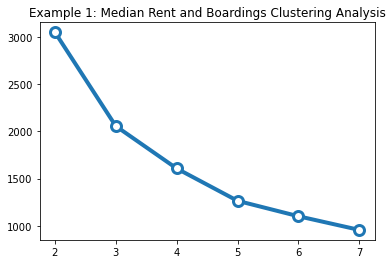

In [11]:
# Example 1: Number of clusters to try out for median_rent and boardings.
scaler = StandardScaler()
rent_boarding_scaled = scaler.fit_transform(chicago_data_filter[['median_rent', 'boardings']])

n_clusters = list(range(2, 8))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rent_boarding_scaled)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3)
plt.title('Example 1: Median Rent and Boardings Clustering Analysis')

In [12]:
# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

4


Text(0.5, 1.0, 'Example 1: Median Age and Boardings Clustering Analysis')

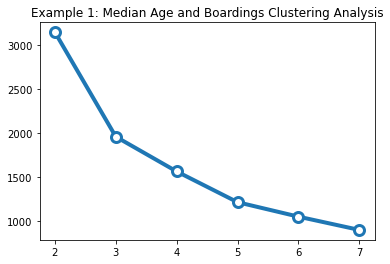

In [13]:
# Example 2: Number of clusters to try out for median_age and boardings.
age_boarding_scaled = scaler.fit_transform(chicago_data_filter[['median_age', 'boardings']])

n_clusters = list(range(2, 8))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(age_boarding_scaled)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3)
plt.title('Example 1: Median Age and Boardings Clustering Analysis')

In [14]:
# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

3


To better analyze the relationship between boardings and certain socioeconomic variables, we applied DBSCAN clusters on three variables: total_pop, median_rent,median_income, and boardings. 
Since our dataset is relatively small (there are 2327 rows in the chicago_data dataset, representing 2327 block groups in Chicago), we set the min_samples in DBSCAN to 5 to idealize the number of clusters the function could return.
According to the avg_values result shows, the largest cluster of block groups has an average boarding of 33.404225, and the average population is around 1034. Both variables are relatively low among the top 5 clusters. The average median income is about 71421, which is relatively high among the top 5 clusters. Also, the cluster labeled 8 has the highest average boardings value, and this group is also associated with the lowest rent and income and highest population density. From here, we could roughly conclude that the number of boardings might be negatively related to median rent and median income while positively related to the total population. 

In [15]:
# DBSCAN clusters:
chicago_data_filter
feature = chicago_data_filter[['total_pop','median_rent','median_income','boardings']]

In [16]:
# DBSCAN clusters
# Scale these features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature)
scaled_features

array([[ 0.49269214, -0.96045388, -0.96233812,  0.80778805],
       [-0.10332067, -0.97157865, -1.09220774, -0.68992204],
       [ 1.20728342,  1.34237459,  1.45451056,  0.75947482],
       ...,
       [-0.10332067, -1.04667089, -0.00868979, -0.48700648],
       [-0.06899532, -0.84920613, -0.89183073, -0.53531971],
       [-0.30147153, -0.92707955, -0.61660227, -0.7865485 ]])

In [17]:
# Run DBSCAN 
cores, labels = dbscan(scaled_features, eps=0.25, min_samples=5)
# Add the labels back to the original (unscaled) dataset
feature['label'] = labels

C:\Users\m1861\AppData\Local\Temp/ipykernel_1932/2155207153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['label'] = labels


In [18]:
# Extract the number of clusters 
num_clusters = feature['label'].nunique() - 1
print(num_clusters)

21


In [19]:
N = feature.groupby('label').size()
N.head(5)

label
-1    1489
 0     710
 1      37
 2       5
 3       5
dtype: int64

In [20]:
#sort from largest to smallest
N = N.sort_values(ascending= False)

In [21]:
# extract labels (ignoring label -1 for noise)
top5 = N.iloc[1:6]
top5

label
0     710
1      37
13      7
8       7
7       6
dtype: int64

In [22]:
top5_labels = top5.index.tolist()

In [23]:
# get the features for the top 5 labels
selection = feature['label'].isin(top5_labels)

# select top 5 and groupby by the label
grps = feature.loc[selection].groupby('label')

# calculate average pickup hour and trip distance per cluster
avg_values = grps[['total_pop', 'median_rent','median_income','boardings']].mean()
avg_values

total_pop  median_rent  median_income  boardings
label                                                    
0      1033.966197  1043.955429   71421.097438  33.404225
1      1817.513514   936.756757   45720.648649  44.621622
7       116.500000  1145.338710   84062.056814   7.500000
8      1325.714286   748.428571   27527.857143  94.428571
13     1715.000000  1079.142857   48504.142857  39.714286

To avoid multicollinearity in the future model building process, we run a correlation test on all the selected predictors. As the Correlation Among Selected Predictors graphic shows, the variable educational_attinment_pop25 and total_pop are highly correlated(0.94), therefore, we will avoid using both predictors in the same model in the further modeling process. 

Text(0.5, 1.0, 'Correlation Among Selected Predictors')

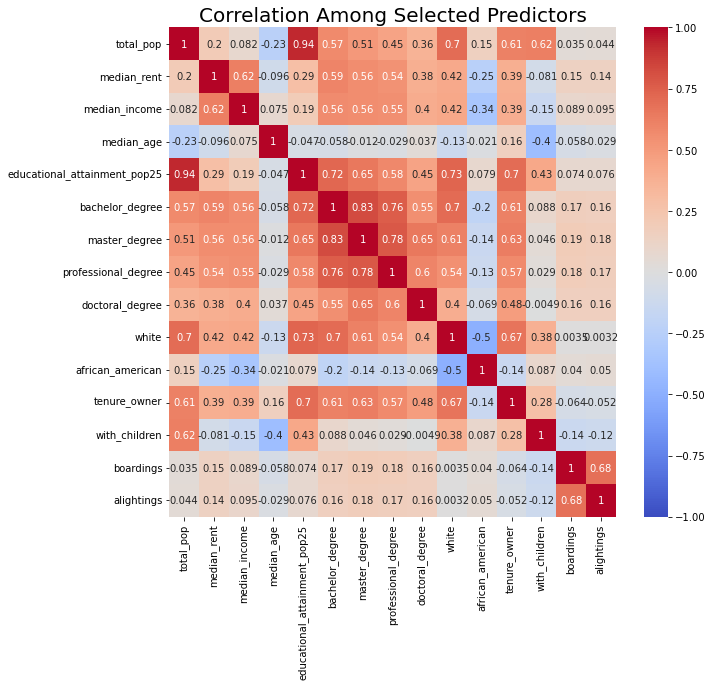

In [24]:
## check correlatino
# The features
plt.figure(figsize=(10,9))
feature_cols = [col for col in chicago_data_filter]
sns.heatmap(
    chicago_data_filter[feature_cols].corr(), 
    cmap="coolwarm", 
    annot=True, 
    vmin=-1, 
    vmax=1,
)
plt.title("Correlation Among Selected Predictors", fontsize = 20) # title with fontsize 20


In [38]:
from folium.plugins import HeatMap

m = folium.Map(
    location=[41.89051776994878, -87.62846577303873], tiles="Cartodb Positron", zoom_start=11
)

# convert to coordinates array
# Syntax is (lat, lng)
coordinates = bus_ridership[["latitude", "longitude"]].values

# add heat map
HeatMap(coordinates).add_to(m)

m